We apply polygon-based segmentation (or plain image thresholding) to scans exhibiting the evolution from __double-dots__ to __blurry intersections__ to __disconnected clean triangles__ in space & explore a metric (stopping criterion) for the adjustment of barrier-voltages based on the average number of detected/fitted polygon edges

One of the challenges is to conduct this with lower resolution settings - the results appear related to the precision supplied to polygon-approximation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from tqdm import tqdm
from pathlib import Path
import cv2 as cv

root_dir = ""

data_path  = 'stab_diagrams'
nanowire_data = []
for filename in tqdm(Path(data_path).rglob("*.pkl")):
    nanowire_data.append(pickle.load(open(filename, "rb")))

10it [00:00, 27.99it/s]


# Unordered Data

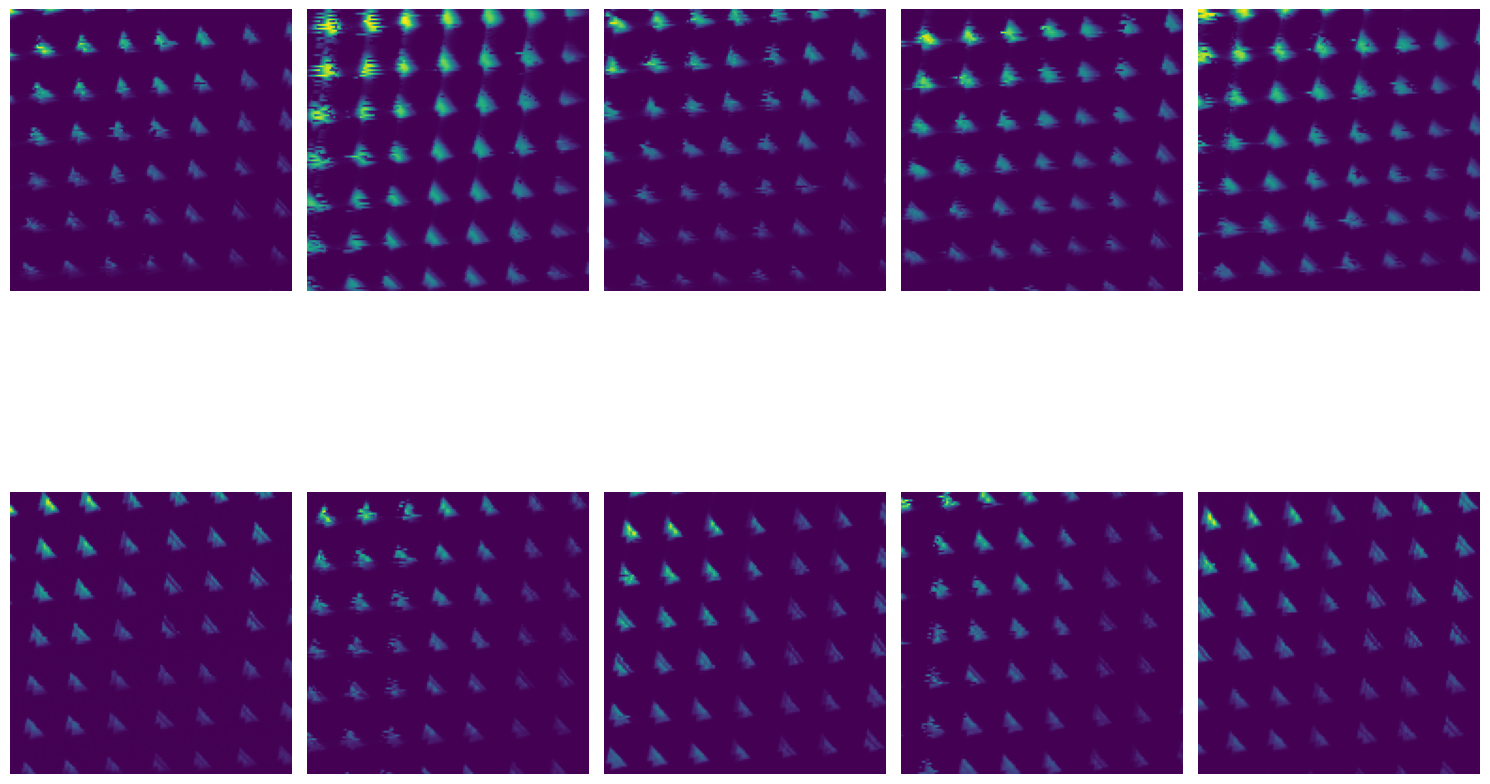

In [2]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize= (15, 12),sharex=True, sharey=True)
    
for i in range(2):
    for j in range(5):
        
           ax[i,j].imshow(-nanowire_data[i*5+j]['numpy'])
           ax[i,j].axis('off') 
           
fig.tight_layout()
plt.show() 

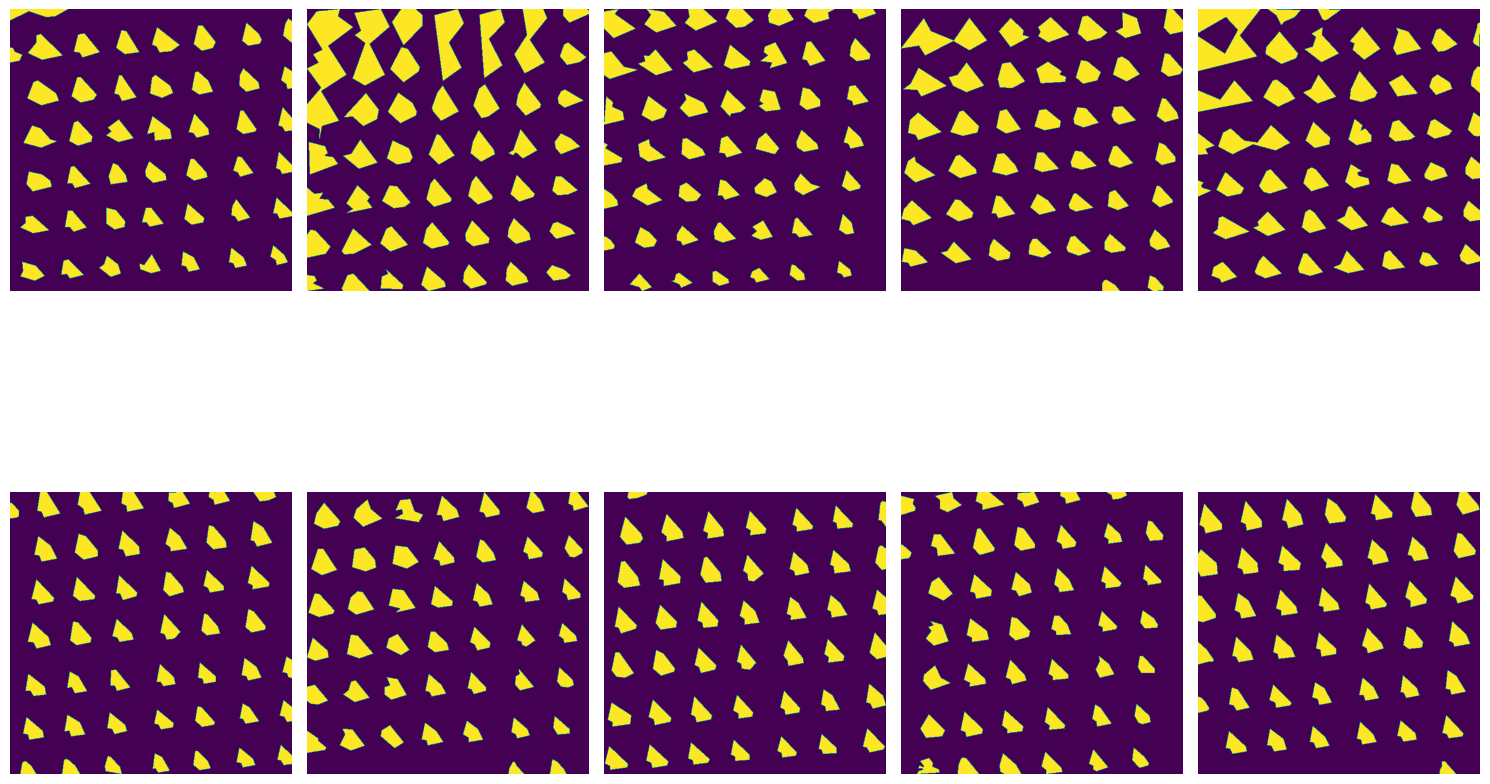

In [3]:
from btriangle_detection import triangle_segmentation_alg

fig, ax = plt.subplots(nrows=2, ncols=5, figsize= (15, 12),sharex=True, sharey=True)
    
for i in range(2):
    for j in range(5):
        
           res_h = 4
           min_area_h = (nanowire_data[i*5+j]['numpy'].shape[0]*nanowire_data[i*5+j]['numpy'].shape[1]*res_h*res_h)*0.001
           unblocked, ims, masks = triangle_segmentation_alg(-nanowire_data[i*5+j]['numpy'],res = res_h,min_area = min_area_h, thr_method = 'triangle', denoising = True, allow_MET = False, direction = 'down')
           ax[i,j].imshow(masks)
           ax[i,j].axis('off') 
           
fig.tight_layout()
plt.show() 

In [4]:
def count_edges(mask: np.ndarray, eps: float = 0.01) -> float:    
    
    c, _ = cv.findContours(mask,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
    peri = cv.arcLength(c[0], True)
    approx = cv.approxPolyDP(c[0], eps * peri, True)
    no_edges = len(approx)
    
    return no_edges


stat_pairs = []
for i in range(len(nanowire_data)):
    
    unblocked, ims, masks = triangle_segmentation_alg(-nanowire_data[i]['numpy'],res = res_h,min_area = 3, thr_method = 'triangle', denoising = True, allow_MET = False, direction = 'down')
    ret, labels = cv.connectedComponents(masks)
    no_edges = []
    
    for label in range(1,ret):
        mask_edge = np.uint8(np.zeros_like(labels))
        mask_edge[labels == label] = 255
        no_edges.append(count_edges(mask_edge))
    stat_pairs.append([np.round(np.mean(no_edges),2), np.round(np.std(no_edges),1), len(no_edges)-1])

# Unordered with Stats

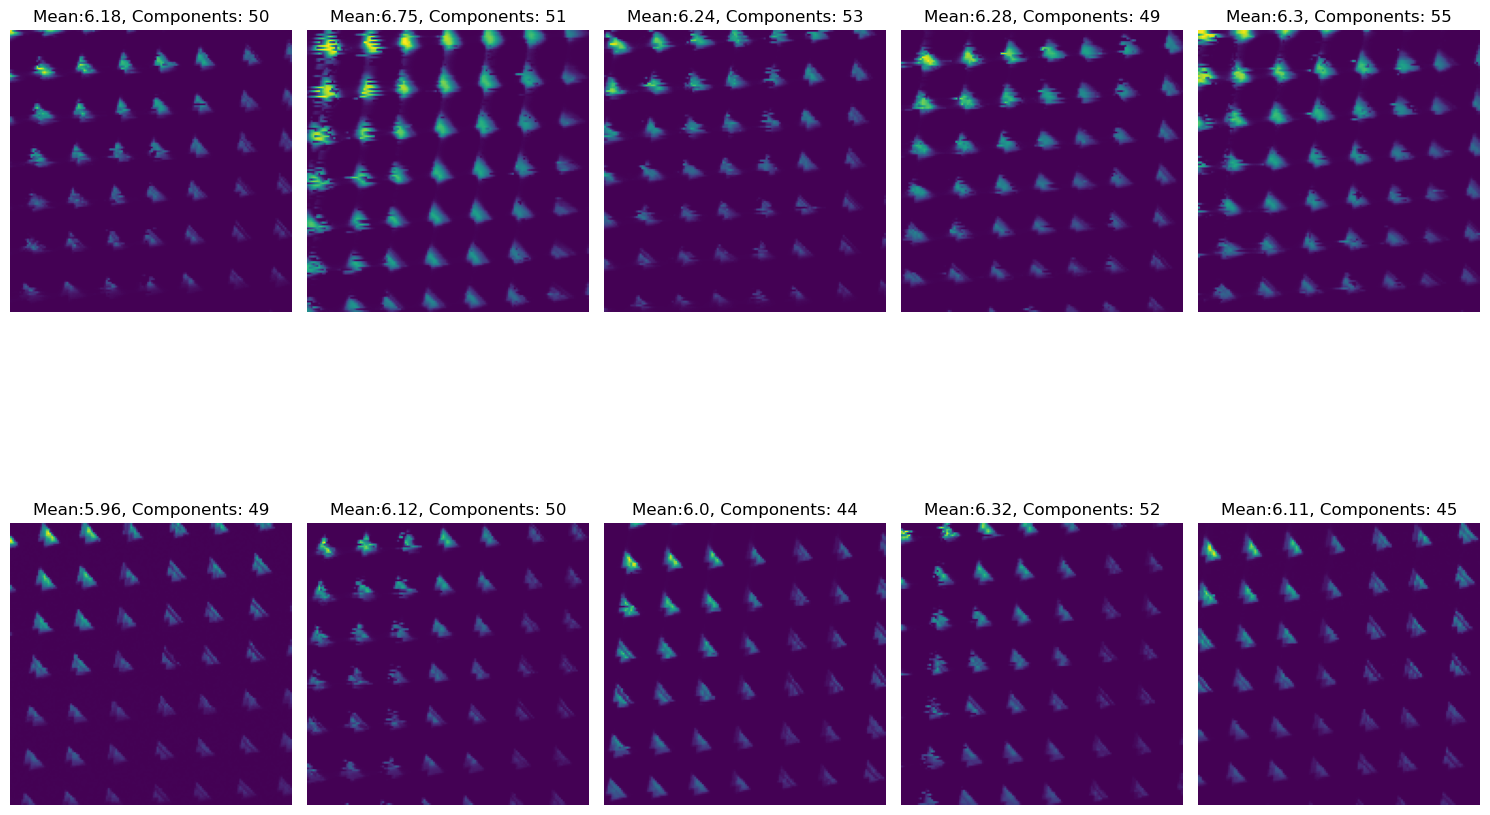

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize= (15, 12),sharex=True, sharey=True)
    
for i in range(2):
    for j in range(5):
        
           ax[i,j].imshow(-nanowire_data[i*5+j]['numpy'])
           ax[i,j].axis('off') 
           ax[i,j].set_title('Mean:'+str(stat_pairs[i*5+j][0])+', Components: '+ str(stat_pairs[i*5+j][2]))
           
fig.tight_layout()
plt.show() 

# Ordered with Stats

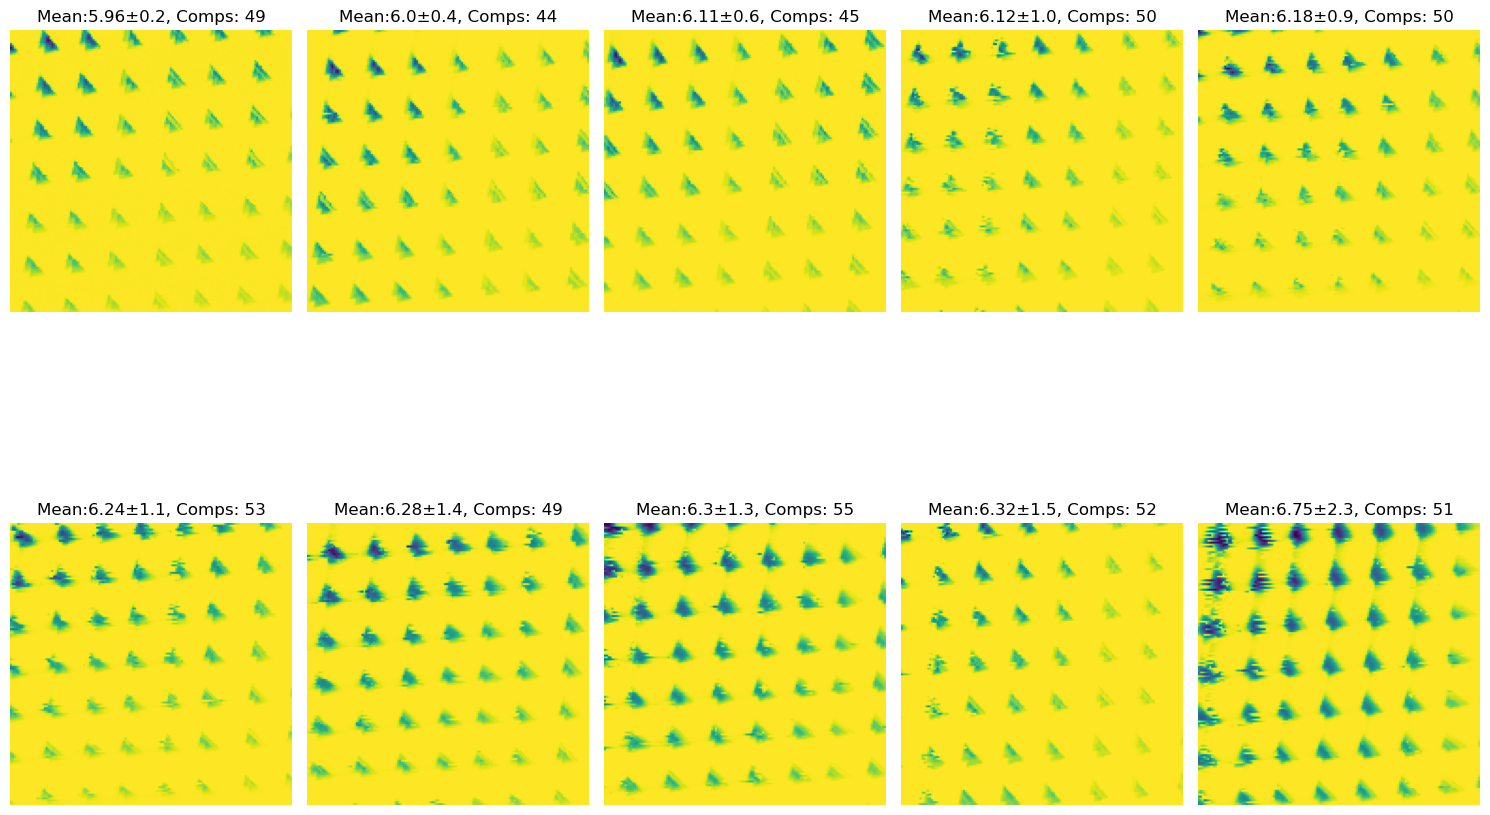

In [6]:
idx = np.argsort(np.array(stat_pairs)[:,0])
nanowire_data2 = []

for i in idx:
     nanowire_data2.append(nanowire_data[i]['numpy'])
        
stat_pairs2 = np.array(stat_pairs)[idx]        
        
fig, ax = plt.subplots(nrows=2, ncols=5, figsize= (15, 12),sharex=True, sharey=True)
    
for i in range(2):
    for j in range(5):
        
           res_h = 4
           #min_area_h = (nanowire_data[i*5+j]['numpy'].shape[0]*nanowire_data[i*5+j]['numpy'].shape[1]*res_h*res_h)*0.001
           #unblocked, ims, masks = triangle_segmentation_alg(-nanowire_data2[i*5+j],res = res_h,min_area = min_area_h, thr_method = 'triangle', denoising = True, allow_MET = False, direction = 'down')
           ax[i,j].imshow(nanowire_data2[i*5+j])
           ax[i,j].axis('off') 
           ax[i,j].set_title('Mean:'+str(stat_pairs2[i*5+j][0])+f'\u00B1'+str(stat_pairs2[i*5+j][1])+', Comps: '+ str(int(stat_pairs2[i*5+j][2])))
           
fig.tight_layout()
plt.show() 

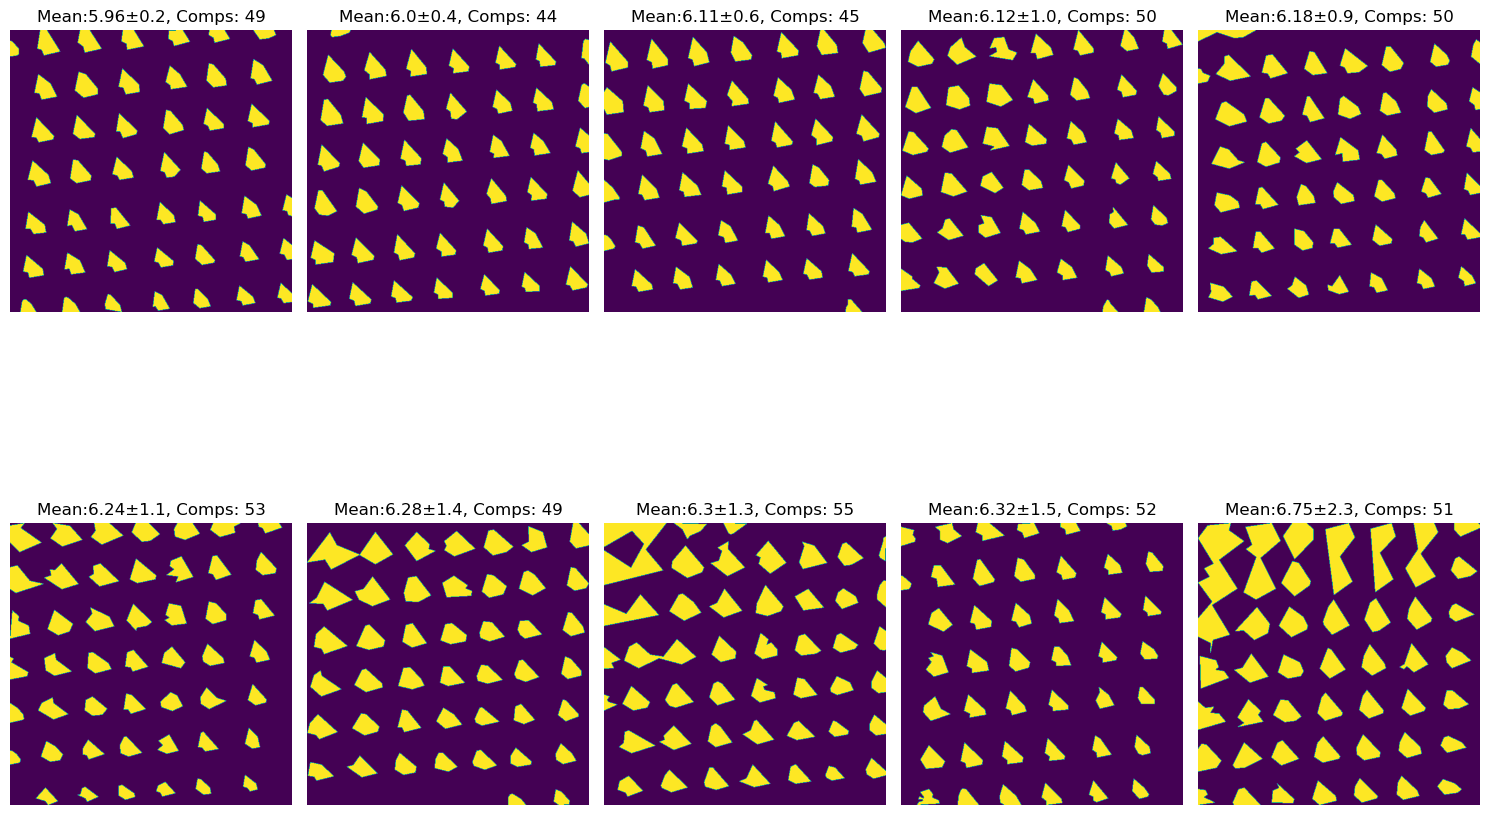

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize= (15, 12),sharex=True, sharey=True)
    
for i in range(2):
    for j in range(5):
        
           res_h = 4
           #min_area_h = (nanowire_data[i*5+j]['numpy'].shape[0]*nanowire_data[i*5+j]['numpy'].shape[1]*res_h*res_h)*0.001
           unblocked, ims, masks = triangle_segmentation_alg(-nanowire_data2[i*5+j],res = res_h,min_area = min_area_h, thr_method = 'triangle', denoising = True, allow_MET = False, direction = 'down')
           ax[i,j].imshow(masks)
           ax[i,j].axis('off') 
           stat_pairs2 = np.array(stat_pairs)[idx]
           ax[i,j].set_title('Mean:'+str(stat_pairs2[i*5+j][0])+f'\u00B1'+str(stat_pairs2[i*5+j][1])+', Comps: '+ str(int(stat_pairs2[i*5+j][2])))
           
fig.tight_layout()
plt.show() 

# Resolution Robustness Test

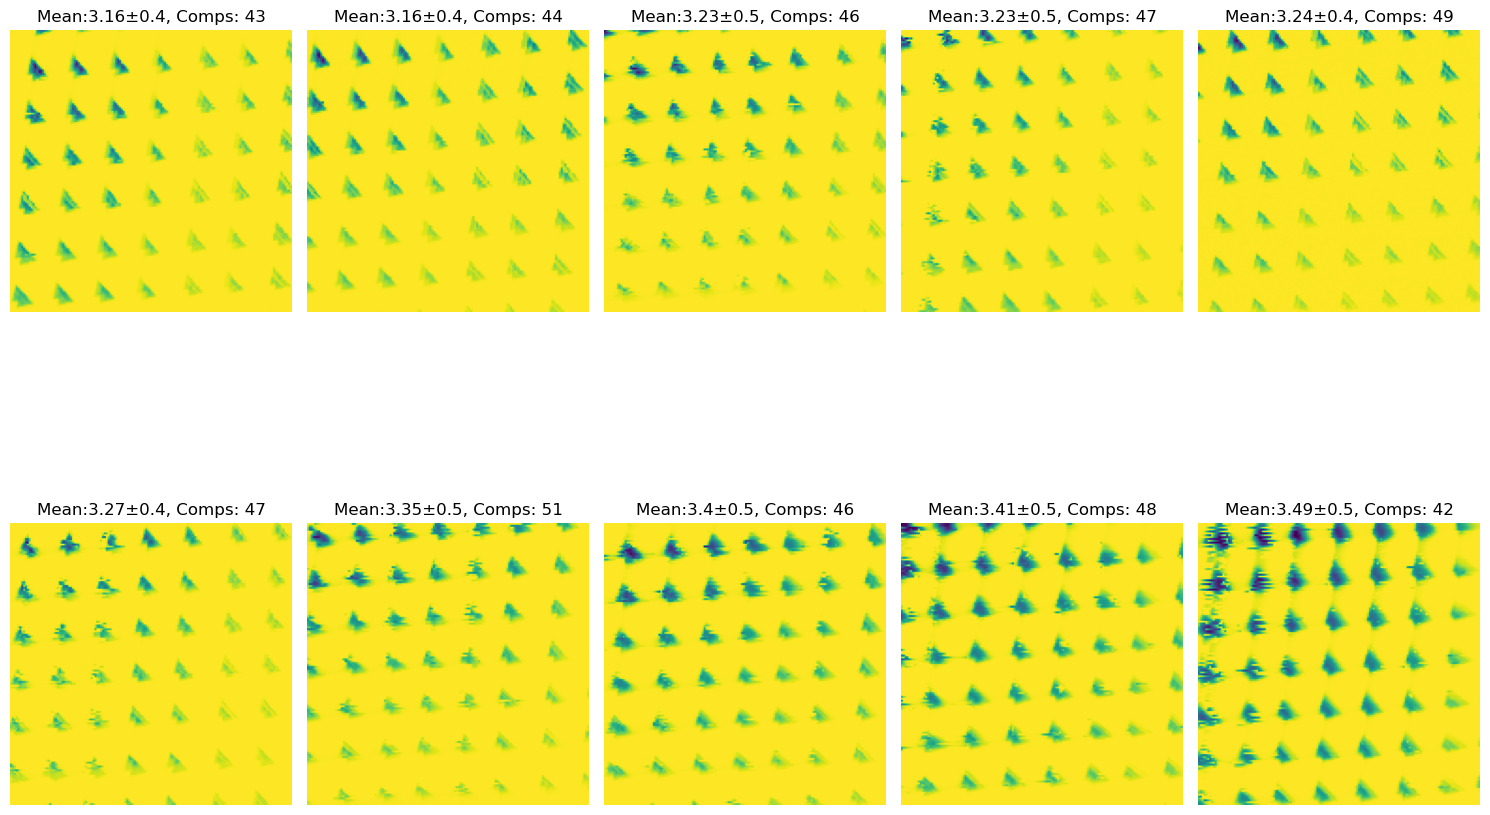

In [15]:
stat_pairs = []
for i in range(len(nanowire_data)):
    
    data = -nanowire_data[i]['numpy']
    w,h = data.shape
    resized = cv.resize(data, (w//2, h//2))
    
    unblocked, ims, masks = triangle_segmentation_alg(resized,res = res_h,min_area = 3, thr_method = 'triangle', denoising = True, allow_MET = False, direction = 'down')
    ret, labels = cv.connectedComponents(masks)
    no_edges = []
    
    for label in range(1,ret):
        mask_edge = np.uint8(np.zeros_like(labels))
        mask_edge[labels == label] = 255
        no_edges.append(count_edges(mask_edge,eps = 0.1))# or 0.001
    stat_pairs.append([np.round(np.mean(no_edges),2), np.round(np.std(no_edges),1), len(no_edges)-1])

idx = np.argsort(np.array(stat_pairs)[:,0])
nanowire_data2 = []

for i in idx:
     nanowire_data2.append(nanowire_data[i]['numpy'])
        
stat_pairs2 = np.array(stat_pairs)[idx]        
        
fig, ax = plt.subplots(nrows=2, ncols=5, figsize= (15, 12),sharex=True, sharey=True)
    
for i in range(2):
    for j in range(5):
        
           res_h = 4
           #min_area_h = (nanowire_data[i*5+j]['numpy'].shape[0]*nanowire_data[i*5+j]['numpy'].shape[1]*res_h*res_h)*0.001
           #unblocked, ims, masks = triangle_segmentation_alg(-nanowire_data2[i*5+j],res = res_h,min_area = min_area_h, thr_method = 'triangle', denoising = True, allow_MET = False, direction = 'down')
           ax[i,j].imshow(nanowire_data2[i*5+j])
           ax[i,j].axis('off') 
           ax[i,j].set_title('Mean:'+str(stat_pairs2[i*5+j][0])+f'\u00B1'+str(stat_pairs2[i*5+j][1])+', Comps: '+ str(int(stat_pairs2[i*5+j][2])))
           
fig.tight_layout()
plt.show() 

# General Dataset

<DirEntry 'date_20220219_random_search'>
<DirEntry '.ipynb_checkpoints'>
couldn't load
<DirEntry 'errors'>
couldn't load
<DirEntry 'run0'>
couldn't load
<DirEntry 'date_20220217_corner_finding_full_runs'>
<DirEntry 'run2'>


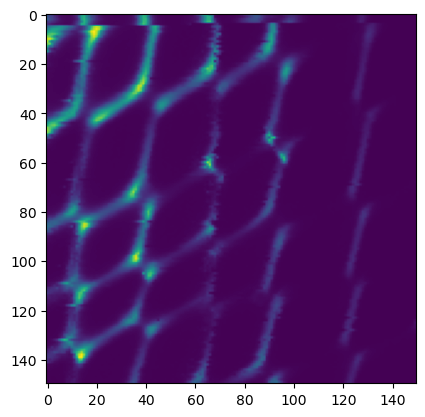

<DirEntry 'run5'>


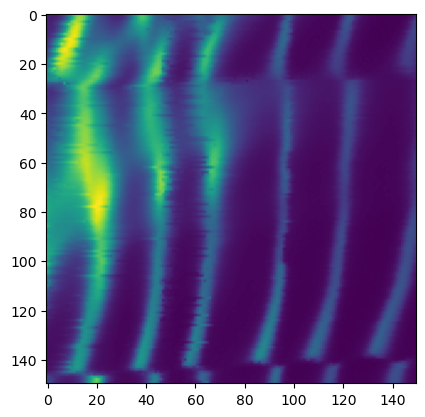

<DirEntry 'run4'>


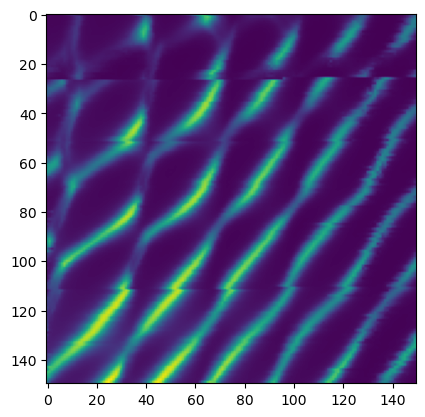

<DirEntry 'run3'>
couldn't load
<DirEntry 'run10'>


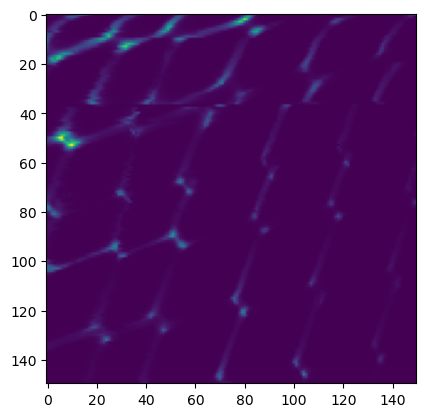

<DirEntry 'errors'>
couldn't load
<DirEntry 'run6'>


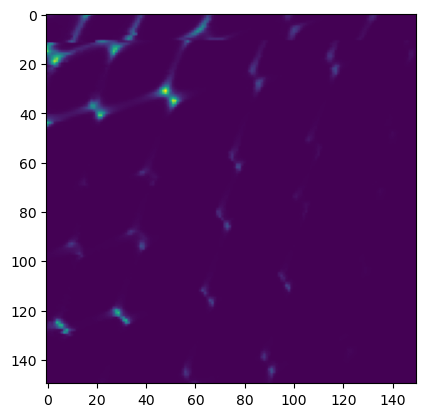

<DirEntry 'run1'>


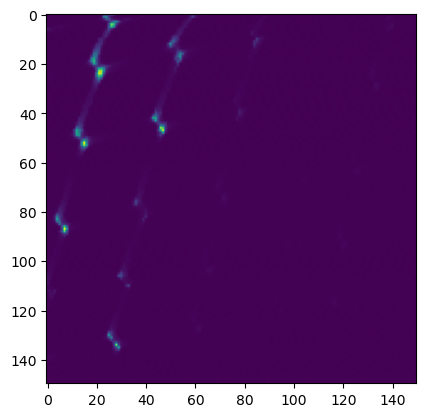

<DirEntry 'run8'>


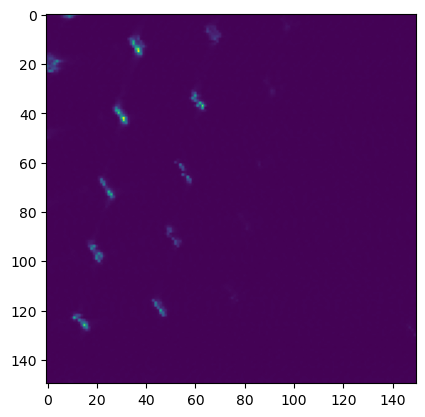

<DirEntry 'run9'>


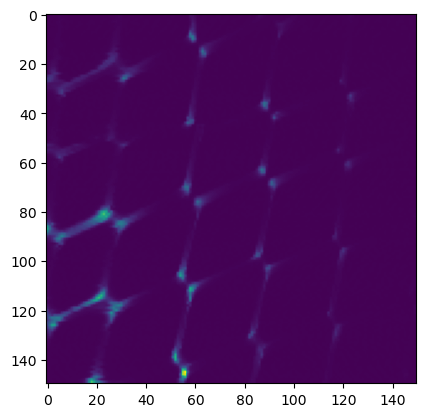

<DirEntry 'run0'>


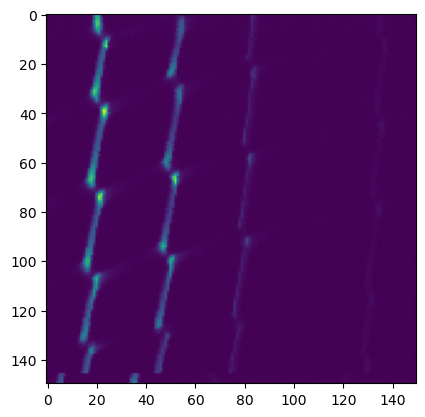

<DirEntry 'run7'>


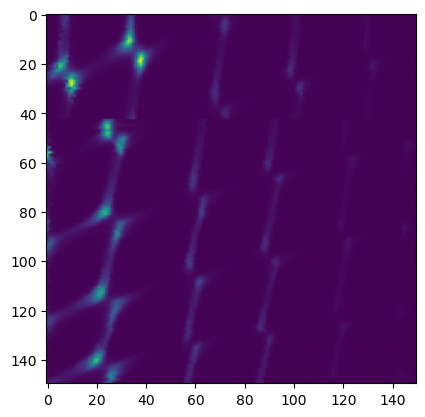

<DirEntry '21-33-52_qtt_PL_PM_Transition_Bias_-0.4'>


FileNotFoundError: [Errno 2] No such file or directory: 'ist3_data/21-33-52_qtt_PL_PM_Transition_Bias_-0.4/data'

In [16]:
#Older data: available in Quatum restricted/OU/Data_for_MF_2.zip
root_dir = "ist3_data"
imgs = []
for folder in os.scandir(root_dir):
    print(folder)
    for run_folder in os.scandir(os.path.join(folder, "data")):
        print(run_folder)
        try:
            d = np.load(os.path.join(run_folder, "current_maps.npy"), allow_pickle=True)
            plt.imshow(d[-1]["ultra_high_res_scan"])
            imgs.append(d[-1]["ultra_high_res_scan"])
            plt.show()
        except:
            print("couldn't load")

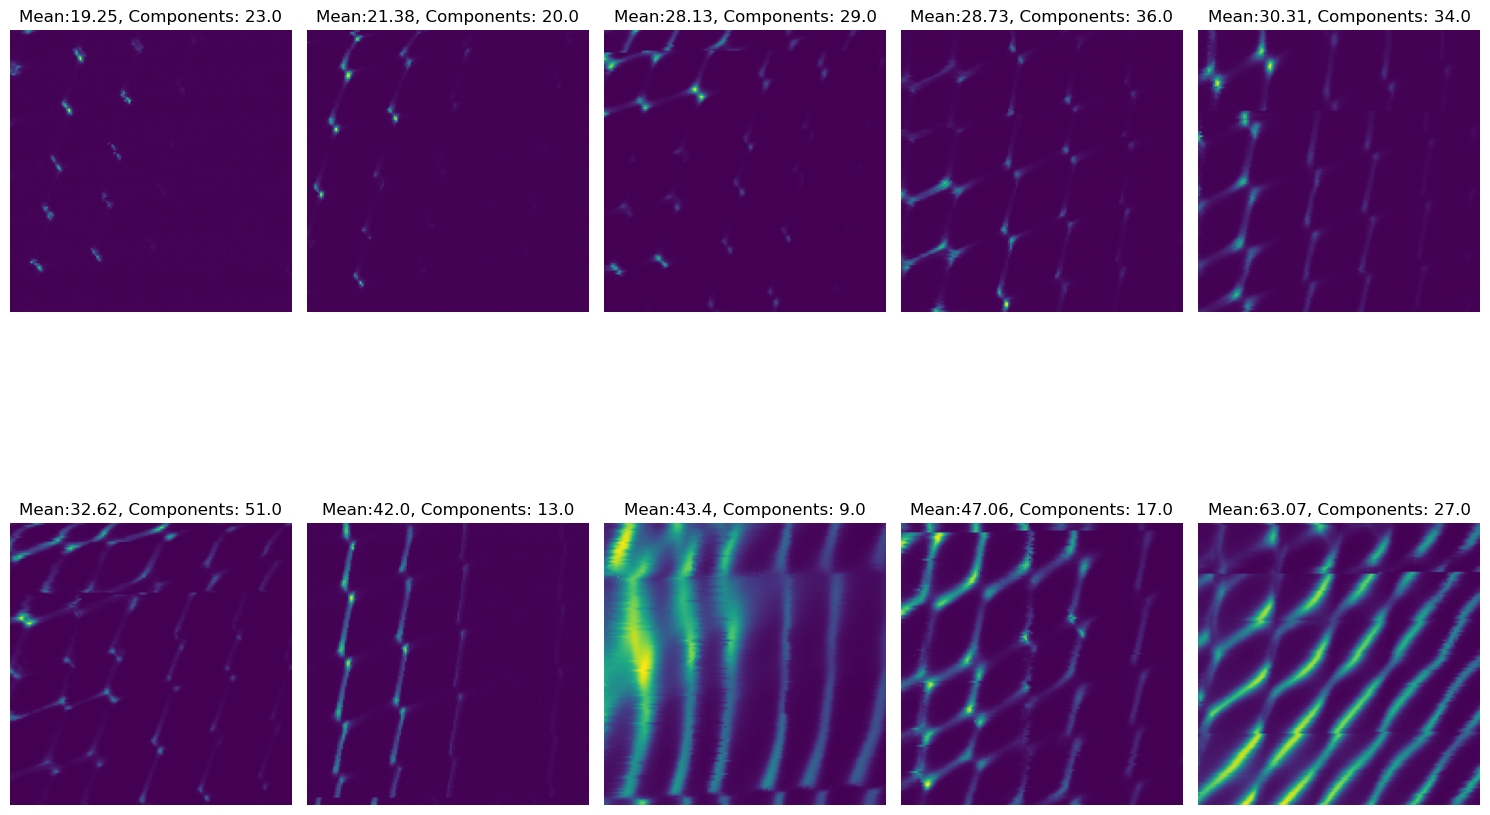

In [17]:
import im_utils

def simple_thresh(img):
    gray = im_utils.img_res_gray(img, 2)
    gray_orig = np.copy(gray)
    _, threshold = cv.threshold(gray, 0, 255, cv.THRESH_TRIANGLE)
    
    return threshold
    
stat_pairs = []
for i in range(len(imgs)):
    
    masks = simple_thresh(imgs[i])
    ret, labels = cv.connectedComponents(masks)
    no_edges = []
    
    for label in range(1,ret):
        
        mask_edge = np.uint8(np.zeros_like(labels))
        
        mask_edge[labels == label] = 255
        no_edges.append(count_edges(mask_edge, eps= 0.001))
        
    stat_pairs.append([np.round(np.mean(no_edges),2), np.std(no_edges), len(no_edges)-1])

    
    
idx = np.argsort(np.array(stat_pairs)[:,0])
stat_pairs2 = np.array(stat_pairs)[idx]

data3 = []
for i in idx:
     data3.append(imgs[i])  
        
fig, ax = plt.subplots(nrows=2, ncols=5, figsize= (15, 12),sharex=True, sharey=True)
    
for i in range(2):
    for j in range(5):
        
           masks = simple_thresh(data3[i*5+j])
           ax[i,j].imshow(data3[i*5+j])
           ax[i,j].axis('off') 
           ax[i,j].set_title('Mean:'+str(stat_pairs2[i*5+j][0])+', Components: '+ str(stat_pairs2[i*5+j][2]))
           
fig.tight_layout()
plt.show() 

# Resolution Robustness Test

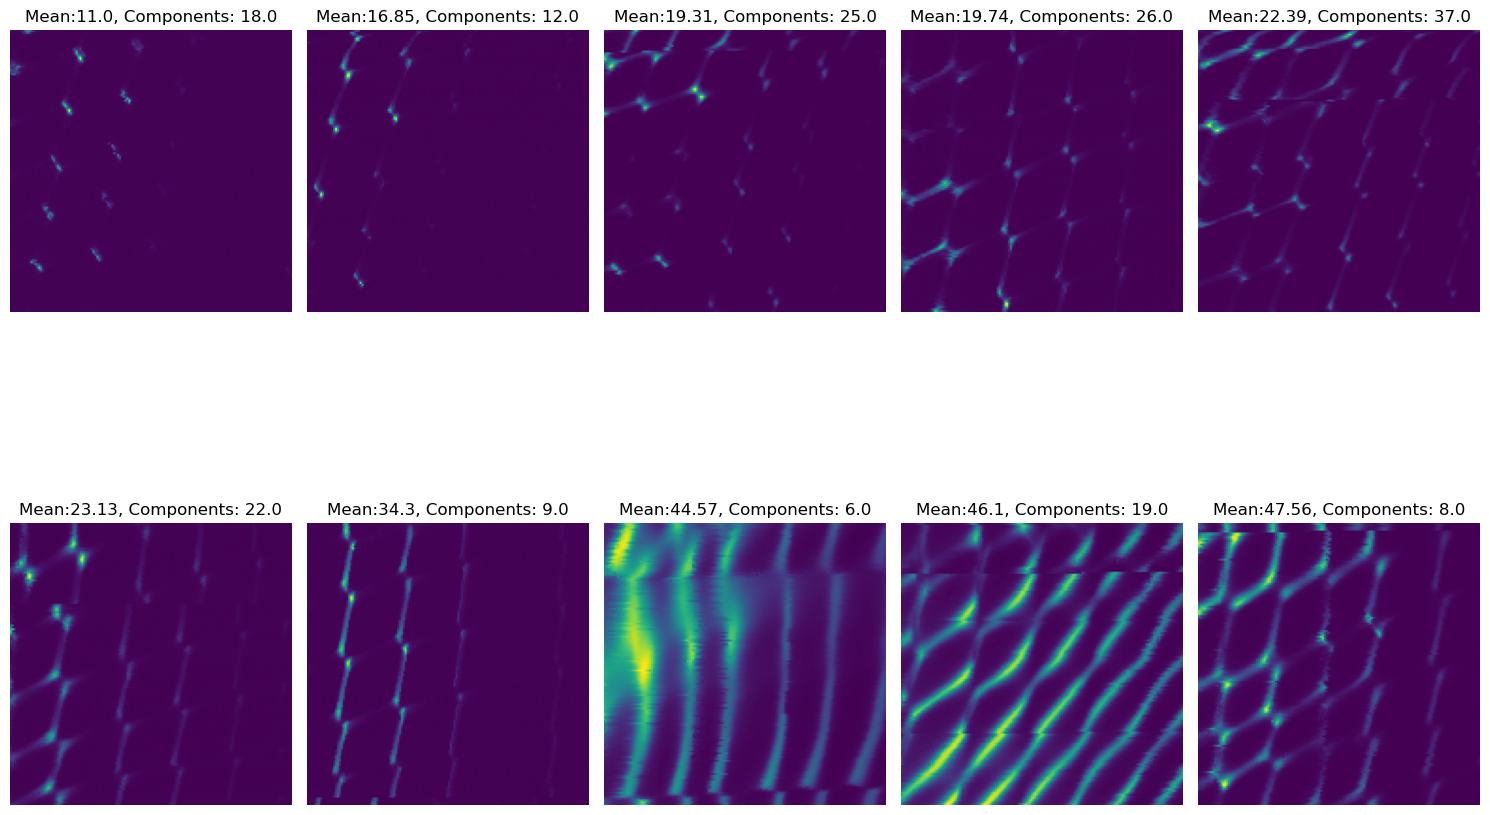

In [18]:
stat_pairs = []
for i in range(len(imgs)):
    
    w,h = imgs[i].shape
    resized = cv.resize(imgs[i], (w//2, h//2))
    
    masks = simple_thresh(resized)
    ret, labels = cv.connectedComponents(masks)
    no_edges = []
    
    for label in range(1,ret):
        
        mask_edge = np.uint8(np.zeros_like(labels))
        
        mask_edge[labels == label] = 255
        no_edges.append(count_edges(mask_edge, eps= 0.001))
        
    stat_pairs.append([np.round(np.mean(no_edges),2), np.std(no_edges), len(no_edges)-1])

    
    
idx = np.argsort(np.array(stat_pairs)[:,0])
stat_pairs2 = np.array(stat_pairs)[idx]

data3 = []
for i in idx:
     data3.append(imgs[i])  
        
fig, ax = plt.subplots(nrows=2, ncols=5, figsize= (15, 12),sharex=True, sharey=True)
    
for i in range(2):
    for j in range(5):
        
           masks = simple_thresh(data3[i*5+j])
           ax[i,j].imshow(data3[i*5+j])
           ax[i,j].axis('off') 
           ax[i,j].set_title('Mean:'+str(stat_pairs2[i*5+j][0])+', Components: '+ str(stat_pairs2[i*5+j][2]))
           
fig.tight_layout()
plt.show() 